In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact

In [4]:
from collections.abc import Iterable, Iterator
from typing import Any, List


class MyIterator(Iterator):
    _position: int = None
    _reverse: bool = False

    def __init__(self, collection: Iterable, reverse: bool = False) -> None:
        self._collection = collection
        self._reverse = reverse
        self._position = -1 if reverse else 0

    def __next__(self):
        try:
            value = self._collection[self._position]
            self._position += -1 if self._reverse else 1
        except IndexError:
            raise StopIteration()

        return value


class MyCollection(Iterable):
    def __init__(self, collection: Iterable = []) -> None:
        self._collection = list(collection)

    def __iter__(self) -> MyIterator:
        return MyIterator(self._collection)

    def get_reverse_iterator(self) -> MyIterator:
        return MyIterator(self._collection, True)
    
    def sort_items(self):
        self._collection.sort()

    def add_item(self, item):
        self._collection.append(item)

In [5]:
from typing import Optional


class SingletonMeta(type):
    _instance = None

    def __call__(self):
        if self._instance is None:
            self._instance = super().__call__()
        return self._instance


class DataFrameSingleton(metaclass=SingletonMeta):
    def __init__(self, df=None):
        if df is not None:
            self.__df = df
        
    @property
    def df(self):
        return self.__df
    
    @df.setter
    def df(self, df):
        self.__df = df

In [6]:
from abc import ABC, abstractmethod


class Bus(ABC):
    @abstractmethod
    def get_df(self) -> pd.DataFrame:
        pass


class BusFromCsv(Bus):
    def get_df(self) -> pd.DataFrame:
        return pd.read_csv('bus.csv', index_col='номер маршрута')


class BusFromJson(Bus):
    def get_df(self) -> pd.DataFrame:
        df = pd.read_json('bus.json')
        df.index.name = 'номер маршрута'
        return df


class Train(ABC):
    @abstractmethod
    def get_df(self) -> pd.DataFrame:
        pass


class TrainFromCsv(Train):
    def get_df(self) -> pd.DataFrame:
        return pd.read_csv('train.csv', index_col='номер маршрута')

    
class TrainFromJson(Train):
    def get_df(self) -> pd.DataFrame:
        df = pd.read_json('train.json')
        df.index.name = 'номер маршрута'
        return df


class AbstractFactory(ABC):
    @abstractmethod
    def create_bus(self) -> Bus:
        pass

    @abstractmethod
    def create_train(self) -> Train:
        pass


class CsvFactory(AbstractFactory):
    def create_bus(self) -> BusFromCsv:
        return BusFromCsv()

    def create_train(self) -> TrainFromCsv:
        return TrainFromCsv()


class JsonFactory(AbstractFactory):
    def create_bus(self) -> BusFromJson:
        return BusFromJson()

    def create_train(self) -> TrainFromJson:
        return TrainFromJson()

In [7]:
@interact
def choose_vehicle(extension=widgets.Dropdown(description='расширение', options=['csv', 'json']),
                   vehicle=widgets.Dropdown(description='тип транспорта', options=['автобус', 'поезд'])):
    dfs = DataFrameSingleton()
    
    if extension=='csv':
        factory = CsvFactory()
    else:
        factory = JsonFactory()
    
    if vehicle=='автобус':
        bus = factory.create_bus()
        dfs.df = bus.get_df()
    else:
        train = factory.create_train()
        dfs.df = train.get_df()
        
    dfs.df['дата отправления'] = pd.to_datetime(dfs.df['дата отправления']) # date normalization
    dfs.df['время отправления'] = dfs.df['время отправления'].astype('string')

interactive(children=(Dropdown(description='расширение', options=('csv', 'json'), value='csv'), Dropdown(descr…

In [8]:
# df.to_json('train.json')

interactive(children=(Text(value='', description='вокзал отправки'), Text(value='', description='вокзал прибыт…

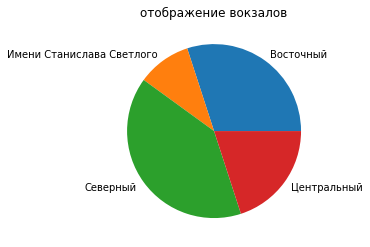

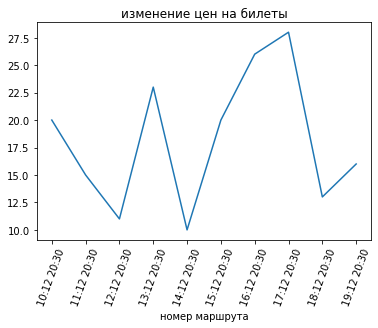

In [9]:
res_df = None

@interact
def choose_destination(
        leave=widgets.Text(description='вокзал отправки'), 
        arrival=widgets.Text(description='вокзал прибытия'),
        leave_date=widgets.DatePicker(description='дата отправления'),
        weekend_setting=widgets.Dropdown(description='отображать', options=['все', 'только выходные', 'только будние']),
        time_start=widgets.IntSlider(description='начало интервала времени', min=0, max=23),
        time_end=widgets.IntSlider(description='конец интервала времени', min=1, max=24, value=24),
        aproximation_amount=widgets.IntSlider(description='назад количество ближайших отображений по дате',
                                              min=1, max=10)
    ):
    global res_df
    res_df = DataFrameSingleton().df.copy()
    
    res_df['hour'] = pd.to_numeric(res_df['время отправления'].str.split(n=1, pat=':').str[0])
    
    res_df = res_df[(res_df['hour'] >= time_start) & (res_df['hour'] <= time_end)]
    res_df = res_df.drop(columns='hour')
    
    if weekend_setting=='только выходные':
        res_df = res_df[res_df['дата отправления'].dt.dayofweek > 4]
        
    if weekend_setting=='только будние':
        res_df = res_df[res_df['дата отправления'].dt.dayofweek < 5]
    
    if leave:
        res_df = res_df[res_df['вокзал отправления'].str.startswith(leave)]
                                          
    if arrival:
        res_df = res_df[res_df['вокзал прибытия'].str.startswith(arrival)]
    
    if leave_date:
        res_df = res_df[res_df['дата отправления'].dt.date<leave_date].sort_values(['дата отправления', 'время отправления']).tail(aproximation_amount)
    
    return res_df


res_df.groupby('вокзал прибытия').size().plot(kind='pie', title='отображение вокзалов')
plt.axis(False)
plt.show()

sorted_df = res_df.sort_values(['дата отправления', 'время отправления'])

sorted_df['стоимость билетов'].plot(title='изменение цен на билеты', rot=70)
labels = sorted_df['дата отправления'].dt.strftime('%d:%m') + ' ' + sorted_df['время отправления']
plt.xticks(range(1, 11), labels=labels)
plt.show()

In [10]:
my_list = MyCollection(df['стоимость билетов'])
my_list.sort_items()

for each in my_list:
    print(each)

NameError: name 'df' is not defined